# Logistic growth models of SARS-CoV-2 strain ratios

This notebook demonstrates univariate and multivariate logistic growth models, with applications to determining the relative proportions of SARS-CoV-2 strains over time.

#### Table of contents

* [Overview](#Overview)
* [Loading data](#Loading-data)
* Simple logistic growth ?
* ...
* ...
* [Regressing against mutations](#Regressing)

## Overview <a name="Overview" />

In [1]:
import os
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("Using GPU")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    print("Using CPU")
smoke_test = ('CI' in os.environ)

Using CPU


## Loading data <a name="Loading-data" />

Our data inputs consist of a few million genetically sampled SARS-CoV-2 viruses, clustered into [PANGO lineages](https://cov-lineages.org), and aggregated into a few hundred regions globally and into 28-day time bins. Preprocessing was performed by Nextstrain's [ncov](https://docs.nextstrain.org/projects/ncov/en/latest/reference/remote_inputs.html) tool, and aggregation was performed by the broad institute's [pyro-cov](https://github.com/broadinstitute/pyro-cov/blob/master/scripts/preprocess_nextstrain.py) tool.

In [2]:
from pyro.contrib.examples.nextstrain import load_nextstrain_counts
dataset = load_nextstrain_counts()

def summarize(x, name=""):
    if isinstance(x, dict):
        for k, v in sorted(x.items()):
            summarize(v, name + "." + k if name else k)
    elif isinstance(x, torch.Tensor):
        print(f"{name}: {type(x).__name__} of shape {tuple(x.shape)} on {x.device}")
    elif isinstance(x, list):
        print(f"{name}: {type(x).__name__} of length {len(x)}")
    else:
        print(f"{name}: {type(x).__name__}")
summarize(dataset)

counts: Tensor of shape (27, 202, 1316) on cpu
features: Tensor of shape (1316, 2634) on cpu
lineages: list of length 1316
locations: list of length 202
mutations: list of length 2634
sparse_counts.index: Tensor of shape (3, 57129) on cpu
sparse_counts.total: Tensor of shape (27, 202) on cpu
sparse_counts.value: Tensor of shape (57129,) on cpu
start_date: datetime
time_step_days: int


The main two pieces of data are a counts tensor and a feature matrix. The `dataset["counts"]` tensor has shape (T,P,S) where `T` is the number of time bins, `P` is the number of places or locations, and `S` is the number of strains or PANGO lineages, and `dataset["counts"][t,p,s]` is the number of samples in that time-place-strain bin. The `dataset["features"]` matrix has shape (S,M) where `S` is the number of strains or PANGO lineages, and `M` is the number of mutations we consider, and `dataset["features"][s,m]` is the portion of samples classified as lineage `s` that exhibit mutation `m` (note this is not quite binary, because each lineage is heterogeneous).

The count data is heavily skewed towards a few large regions and dominant lineages like `B.1.1.7` and `B.1.617.2`.

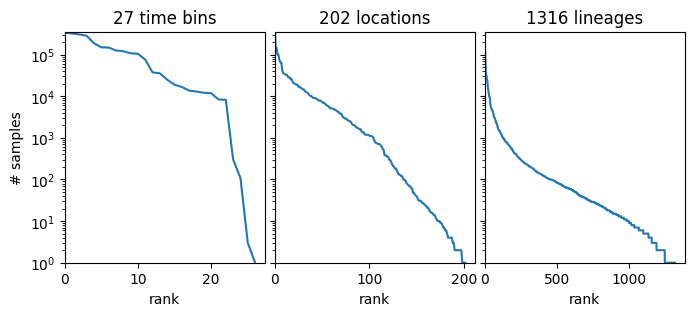

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
for i, name in enumerate(["time bin", "location", "lineage"]):
    counts = dataset["counts"].sum(list({0, 1, 2} - {i}))
    Y = counts.sort(0, True).values
    axes[i].plot(Y)
    axes[i].set_xlim(0, None)
    axes[0].set_ylim(1, None)
    axes[i].set_yscale("log")
    axes[i].set_xlabel(f"rank")
    axes[i].set_title(f"{len(Y)} {name}s")
axes[0].set_ylabel("# samples")
plt.subplots_adjust(wspace=0.05);

We can see that individual mutations rise and fall in prevalence over time.

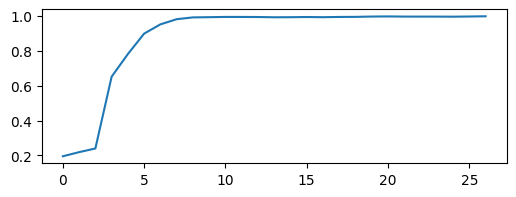

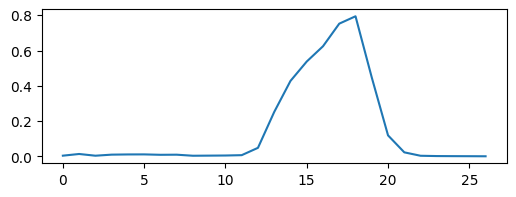

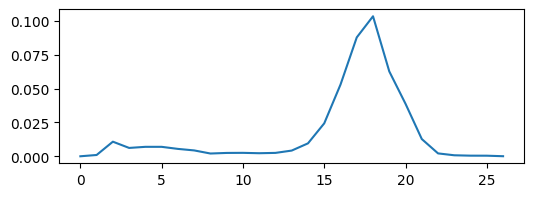

In [4]:
def plot_mutation_growth(mutation):
    m = dataset["mutations"].index(mutation)
    global_counts = dataset["counts"].sum(1)
    portion = global_counts @ dataset["features"][:, m] / global_counts.sum(-1)
    plt.figure(figsize=(6, 2))
    plt.plot(portion)

plot_mutation_growth("S:D614G")
plot_mutation_growth("S:N501Y")
plot_mutation_growth("S:E484K")

## Simple models

In [5]:
def fit_svi(model, lr=0.1, num_steps=1001, log_every=100):
    pyro.clear_param_store()
    pyro.set_rng_seed(20211206)
    if smoke_test:
        num_steps = 2
        
    # Train via mean field variational inference.
    guide = AutoNormal(model, init_scale=0.01)
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / num_steps)})
    svi = SVI(model, guide, optim, Trace_ELBO())
    losses = []
    for step in range(num_steps):
        loss = svi.step()
        losses.append(loss)
        if step % log_every == 0:
            print(f"step {step: >4d} loss = {loss:0.6g}")
            
    # Plot to assess convergence.
    plt.figure(figsize=(6, 3))
    plt.plot(losses)
    plt.xlabel("SVI step")
    plt.ylabel("loss")
    plt.tight_layout()

    return guide

## Regressing against mutations

In [6]:
def model():
    features = dataset["features"]
    counts = dataset["counts"]
    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape
    T, P, S = counts.shape
    time = torch.arange(float(T)) * 5.5 / dataset["time_step_days"]
    time -= time.mean()
    mutation_plate = pyro.plate("mutation", M, dim=-1)
    strain_plate = pyro.plate("strain", S, dim=-1)
    place_plate = pyro.plate("place", P, dim=-2)
    time_plate = pyro.plate("time", T, dim=-3)

    # Model each region as multivariate logistic growth.
    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4, 2))
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    with mutation_plate:
        coef = pyro.sample("coef", dist.Laplace(0, 0.5))
    with strain_plate:
        rate_loc = pyro.deterministic("rate_loc", 0.01 * coef @ features.T)
    with place_plate, strain_plate:
        rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
        init = pyro.sample("init", dist.Normal(0, init_scale))
    logits = init + rate * time[:, None, None]
    
    # Observe sequences via a multinomial likelihood.
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )

In [ ]:
fit_svi(model)